In [ ]:
import torch
import tensorflow as tf

if torch.cuda.is_available():
    print(f"PyTorch: GPU is available - {torch.cuda.get_device_name(0)}")
else:
    print("PyTorch: No GPU available. Using CPU.")

print(f"TensorFlow devices: {tf.config.experimental.list_physical_devices()}")

if tf.config.list_physical_devices('GPU'):
    print("TensorFlow: GPU is available.")
else:
    print("TensorFlow: No GPU available.")


In [ ]:
import os
import string
import numpy as np
import tensorflow as tf
from pickle import dump, load
import time
from PIL import Image
from keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, get_file
from keras.layers import add, Input, Dense, LSTM, Embedding, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm import tqdm

In [ ]:
def load_doc(filename):
    with open(filename, 'r') as file:
        text = file.read()
    return text

In [ ]:
def all_img_captions(filename):
    text = load_doc(filename)
    captions = text.strip().split('\n')
    descriptions = {}
    for caption in captions:
        img, cap = caption.split('\t')
        img = img.split('#')[0]
        if img not in descriptions:
            descriptions[img] = []
        descriptions[img].append(cap)
    return descriptions

In [ ]:
def cleaning_text(captions):
    table = str.maketrans('', '', string.punctuation)
    for img, caps in captions.items():
        for i, cap in enumerate(caps):
            cap = cap.replace("-", " ")
            desc = cap.split()
            desc = [word.lower() for word in desc]
            desc = [word.translate(table) for word in desc]
            desc = [word for word in desc if len(word) > 1]
            desc = [word for word in desc if word.isalpha()]
            captions[img][i] = ' '.join(desc)
    return captions

In [ ]:
def save_descriptions(descriptions, filename):
    lines = []
    for key, caps in descriptions.items():
        for cap in caps:
            lines.append(key + '\t' + cap)
    data = "\n".join(lines)
    with open(filename, "w") as file:
        file.write(data)

In [ ]:
from tqdm import tqdm
import os
import numpy as np
from PIL import Image
from keras.applications.inception_v3 import preprocess_input

def extract_features(directory, model):
    features = {}
    valid_images = ['.jpg', '.jpeg', '.png']
    valid_files = [img for img in os.listdir(directory)
                   if os.path.splitext(img)[1].lower() in valid_images]
    with tqdm(total=len(valid_files), desc="Extracting features", position=0, leave=True) as pbar:
        for img in valid_files:
            filename = os.path.join(directory, img)
            image = Image.open(filename).resize((299, 299))
            if image.mode != 'RGB':
                image = image.convert('RGB')
            image = np.array(image)
            if image.shape[-1] == 4:
                image = image[..., :3]
            image = np.expand_dims(image, axis=0)
            image = preprocess_input(image)
            feature = model.predict(image, verbose=0)
            features[img] = feature
            pbar.update(1)
    return features


In [ ]:
def load_clean_descriptions(filename, photos):
    text = load_doc(filename)
    descriptions = {}
    for line in text.strip().split('\n'):
        tokens = line.split()
        if len(tokens) < 1:
            continue
        image, image_caption = tokens[0], tokens[1:]
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)
    return descriptions

In [ ]:
def load_features(photos, features_file="features.p"):
    all_features = load(open(features_file, "rb"))
    features = {k: all_features[k] for k in photos if k in all_features}
    return features

In [ ]:
def create_tokenizer(descriptions):
    all_desc = []
    for key in descriptions:
        all_desc.extend(descriptions[key])
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(all_desc)
    return tokenizer

In [ ]:
def create_sequences(tokenizer, max_length, desc_list, feature, vocab_size):
    X1, X2, y = [], [], []
    for desc in desc_list:
        seq = tokenizer.texts_to_sequences([desc])[0]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

In [ ]:
def data_generator(descriptions, features, tokenizer, max_length, vocab_size):
    def generator():
        keys = list(descriptions.keys())
        np.random.shuffle(keys)
        for key in keys:
            feature = features[key][0]
            X1, X2, y = create_sequences(tokenizer, max_length, descriptions[key], feature, vocab_size)
            for i in range(len(X1)):
                yield {'input_1': X1[i], 'input_2': X2[i]}, y[i]
    output_signature = (
        {
            'input_1': tf.TensorSpec(shape=(2048,), dtype=tf.float32),
            'input_2': tf.TensorSpec(shape=(max_length,), dtype=tf.int32)
        },
        tf.TensorSpec(shape=(vocab_size,), dtype=tf.float32)
    )
    dataset = tf.data.Dataset.from_generator(generator, output_signature=output_signature)
    dataset = dataset.repeat()
    return dataset.batch(32)

In [ ]:
def get_steps_per_epoch(descriptions):
    total = 0
    for key in descriptions:
        for desc in descriptions[key]:
            total += len(desc.split()) - 1
    return max(1, total // 32)

In [ ]:
def define_model(vocab_size, max_length):
    inputs1 = Input(shape=(2048,), name='input_1')
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    
    inputs2 = Input(shape=(max_length,), name='input_2')
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    model.summary()
    return model

In [ ]:
dataset_text = "training_data/pseudo_caption"
dataset_images = "training_data/dataset"
token_file = "processed/tokenizer.p"
desc_file = "processed/descriptions.txt"
features_file = "processed/features.p"

In [ ]:
if not os.path.exists(desc_file):
    captions_file = os.path.join(dataset_text, "pseudo_caption.txt")
    descriptions = all_img_captions(captions_file)
    descriptions = cleaning_text(descriptions)
    save_descriptions(descriptions, desc_file)
else:
    print("Descriptions file exists.")

In [ ]:
model_extractor = Xception(include_top=False, pooling='avg', weights="imagenet")

In [ ]:
if not os.path.exists(features_file):
    features = extract_features(dataset_images, model_extractor)
    dump(features, open(features_file, "wb"))
else:
    print("Features file exists.")

In [ ]:
all_features = load(open(features_file, "rb"))
photos = list(all_features.keys())
descriptions = load_clean_descriptions(desc_file, photos)

In [ ]:
if not os.path.exists(token_file):
    tokenizer = create_tokenizer(descriptions)
    dump(tokenizer, open(token_file, "wb"))
else:
    tokenizer = load(open(token_file, "rb"))

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size

In [ ]:
all_desc = []
for key in descriptions:
    all_desc.extend(descriptions[key])
max_length_val = max(len(d.split()) for d in all_desc)

In [ ]:
np.random.shuffle(photos)
split_idx = int(0.8 * len(photos))
train_ids = photos[:split_idx]
val_ids = photos[split_idx:]

In [ ]:
train_descriptions = {k: descriptions[k] for k in train_ids if k in descriptions}
val_descriptions = {k: descriptions[k] for k in val_ids if k in descriptions}

In [ ]:
train_features = {k: all_features[k] for k in train_ids if k in all_features}
val_features = {k: all_features[k] for k in val_ids if k in all_features}

In [ ]:
train_dataset = data_generator(train_descriptions, train_features, tokenizer, max_length_val, vocab_size)
val_dataset = data_generator(val_descriptions, val_features, tokenizer, max_length_val, vocab_size)

In [ ]:
steps_train = get_steps_per_epoch(train_descriptions)
steps_val = get_steps_per_epoch(val_descriptions)

In [ ]:
model = define_model(vocab_size, max_length_val)

In [ ]:
if not os.path.exists("models"):
    os.mkdir("models")

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
mc = ModelCheckpoint('models/modelV1.h5', monitor='val_loss', save_best_only=True)

In [ ]:
epochs = 20
history = model.fit(
    train_dataset,
    epochs=epochs,
    steps_per_epoch=steps_train,
    validation_data=val_dataset,
    validation_steps=steps_val,
    callbacks=[es, mc],
    verbose=1
)

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.applications.xception import Xception
from keras.models import load_model
from pickle import load
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.layers import add
from tensorflow.keras.models import Model

In [3]:
def extract_features(filename, model):
    try:
        img = Image.open(filename)
    except Exception as e:
        print("Couldn't open image:", e)
        return None

    img = img.resize((299, 299))
    img = np.array(img)
    if img.shape[-1] == 4:
        img = img[..., :3]
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    feature = model.predict(img)
    return feature

In [4]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [5]:
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text

In [6]:
from keras.utils import plot_model

In [29]:
img_path = "testImage/test1.jpg"

In [30]:
def define_model(vocab_size, max_length):

    inputs1 = Input(shape=(2048,), name='input_1')
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    inputs2 = Input(shape=(max_length,), name='input_2')
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    return model

In [31]:
max_length = 32
tokenizer = load(open("processed/tokenizer.p","rb"))
vocab_size = len(tokenizer.word_index) + 1

In [32]:
vocab_size

386

In [33]:
model = define_model(vocab_size, max_length)

In [34]:
model.load_weights('models/modelV1.h5')
xception_model = Xception(include_top=False, pooling="avg")

In [35]:
photo = extract_features(img_path, xception_model)
img = Image.open(img_path)

1/1 [==============================] - 1s 573ms/step


In [36]:
description = generate_desc(model, tokenizer, photo, max_length)

start person is skateboarding on skateboard end


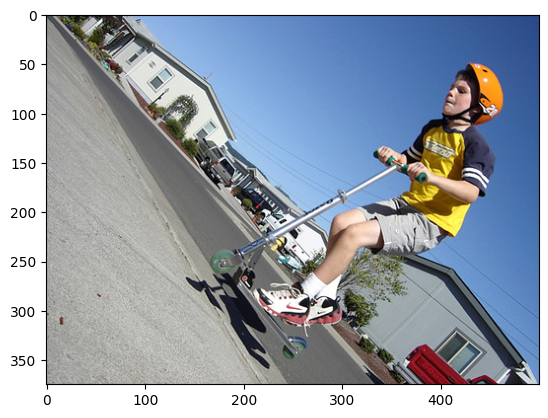

In [37]:
print(description)
plt.imshow(img)